In [3]:
import os
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
import io


import difflib
from googleapiclient.errors import HttpError

In [4]:
SCOPES = ['https://www.googleapis.com/auth/drive.readonly','https://www.googleapis.com/auth/gmail.readonly']

# Setting up Drive and Email Service

1. Create Google Cloud Project
2. Enable Google Drive API and Gmail API under 'APIs & Services'
3. Create Credentials > OAuth CLient ID
4. Choose Desktop/Web App
5. Download Credentials.json
6. Pass it in below function

In [6]:
import getpass
import os

if "drive_secrets_path" not in os.environ:
    drive_secrets = getpass.getpass("drive_secrets_path: ")
    os.environ["drive_secrets_path"] = drive_secrets

if "gmail_secrets_path" not in os.environ:
    gmail_secrets = getpass.getpass("gmail_secrets_path: ")
    os.environ["gmail_secrets_path"] = gmail_secrets

drive_token_path = r"C:\Users\Abhinav\GDrive-AI-Agent\token.json"
gmail_token_path = r"C:\Users\Abhinav\GDrive-AI-Agent\gmail_token.json"

In [7]:
def get_drive_service():
    """Shows basic usage of the Drive v3 API.
    Prints the names and IDs of the first 10 files the user has access to.
    """
    creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists(drive_token_path):
        creds = Credentials.from_authorized_user_file(drive_token_path, SCOPES)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                os.environ["drive_secrets_path"], SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open(drive_token_path, 'w') as token:
            token.write(creds.to_json())

    return build('drive', 'v3', credentials=creds)

In [8]:
drive_service = get_drive_service()

In [9]:
def get_gmail_service():
    creds = None
    if os.path.exists(gmail_token_path):
        creds = Credentials.from_authorized_user_file(gmail_token_path, SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(os.environ["gmail_secrets_path"], SCOPES)
            creds = flow.run_local_server(port=0)
        with open(gmail_token_path, 'w') as token:
            token.write(creds.to_json())

    return build('gmail', 'v1', credentials=creds)

In [10]:
gmail_service = get_gmail_service()

# Try Search a file in Drive

In [64]:
def search_drive_file(service, file_name):
    try:
        results = service.files().list(
            q=f"name='{file_name}' and trashed=false",
            spaces='drive',
            fields='files(id, name)').execute()
        items = results.get('files', [])
        if not items:
            print(f"No file found with name: {file_name}")
            return None
        else:
            print(f"Found file: {items[0]['name']}")            
            return items[0]['id']
    except HttpError as error:
        print(f'An error occurred: {error}')
        return None

In [65]:
import io
import fitz  # PyMuPDF
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.errors import HttpError

def download_drive_file_content(service, file_id, mime_type='application/pdf'):
    try:
        # Request file download
        request = service.files().get_media(fileId=file_id)
        fh = io.BytesIO()
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            print(f"Download {int(status.progress() * 100)}%.")

        # Load PDF content
        fh.seek(0)  # Reset file pointer
        pdf_document = fitz.open("pdf", fh.read())  # Open as PDF
        content = "\n".join([page.get_text("text") for page in pdf_document])  # Extract text
        
        return content  # Return extracted text
    except HttpError as error:
        print(f"An error occurred during download: {error}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [17]:
file_name_to_find = "Abhinav Rohilla Resume.pdf"

In [18]:
#Drive Service
drive_service = get_drive_service()
#Get File Id
file_id = search_drive_file(drive_service, file_name_to_find)
#get file and extract text
file_content = download_drive_file_content(drive_service, file_id)
file_content[:200]

Found file: Abhinav Rohilla Resume.pdf
Download 100%.


' \nAbhinav Rohilla \nData Scientist with 6 years of experience in leveraging machine learning, LLMs and \nstatistics to drive impactful business solutions. Proven ability to understand client \nrequiremen'

# Creating Agent

In [19]:
# from langchain.agents.agent_toolkits import create_python_agent
from langchain_experimental.agents.agent_toolkits import create_python_agent
from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain_experimental.utilities import PythonREPL
# from langchain.tools.python.tool import PythonREPLTool
# from langchain.python import PythonREPL
from langchain.chat_models import ChatOpenAI

In [20]:
from langchain.agents import tool
from datetime import date

In [21]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

import ollama
from ollama import ChatResponse
from IPython.display import display, Markdown, clear_output

In [22]:
# system_message = "You are an AI-powered document retrieval and summarization assistant."
# system_message += "Your primary function is to fetch PDFs from Google Drive, extract relevant text, and generate concise, informative summaries."

### Creating Agent with Langchain pre-built Tools
1. LLM-Math
2. Wikipedia

In [23]:
# from langchain_ollama.llms import OllamaLLM
# llm = OllamaLLM(model="llama3.2")


In [24]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    gemini_api_key = getpass.getpass("Enter your Gemini API key: ")
    os.environ["GOOGLE_API_KEY"] = gemini_api_key

Enter your Gemini API key:  ········


In [25]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",  # or "gemini-1.5-flash"
    # temperature=0.7,
    # max_tokens=1024
)

In [26]:
tools = load_tools(["llm-math","wikipedia"], llm=llm)

In [27]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks import StdOutCallbackHandler
from langchain.callbacks.tracers.langchain import LangChainTracer
tracer = LangChainTracer()

C:\Users\Abhinav\anaconda3\envs\llms\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### ReaAct Framework:
Idea is to breakdown Agent's behaviour into 3 main components:
1. **Thoughts** : Internal reasoning process of the agent
2. **Actions**: Steps agents takes based on thoughts, Tool calling, External API calls, SQL DB calls, any arbitrary python function calls
3. **Observations**: Feedback, agent recieves from Tool. Results from Tools, provide information to refine its thoughts and actions

All components needs LLM calls, with different prompts.
1. Thoughts: A prompt would be drafted like: Given user query, What do I need to check for more information on this?
2. Action: LLM tools are configured with tools description which helps LLM to guide triggering tool if context matches with Tool Description
3. Observation: Summarize the information recieved and did it answer user query?, if Yes trigger final answer prompt

ReAct Flow:
Query -> Agent Initialization -> Thought(LLM-Generated) -> Action(Tool) -> Tool Invocation -> Observation(Result fed back to LLM)
-> New Thought -> Repeat Loop -> Final Answer 



In [66]:
#Initialize Agent
agent= initialize_agent(
    tools, 
    llm, 
    #ReACT, Reasoning and Act
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    #If output of LLM is not parse correctly for other chain
    #It sends back to origin LLM to rephrase
    handle_parsing_errors=True,
    #See in details whats happening in backend
    verbose = True,
# callback_manager=CallbackManager([StdOutCallbackHandler(), tracer])
)

In [29]:
agent("Who is prime minister of India?")

C:\Users\Abhinav\AppData\Local\Temp\ipykernel_2532\2502457097.py:1: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  agent("Who is prime minister of India?")




> Entering new AgentExecutor chain...
Thought: I need to find out who the current prime minister of India is. I can use Wikipedia to find this information.
Action:
```json
{
  "action": "wikipedia",
  "action_input": "Prime Minister of India"
}
```
Observation: Page: Prime Minister of India
Summary: The prime minister of India (ISO: Bhārata kē Pradhānamantrī) is the head of government of the Republic of India. Executive authority is vested in the prime minister and his chosen Council of Ministers, despite the president of India being the nominal head of the executive.  The prime minister has to be a member of one of the houses of bicameral Parliament of India, alongside heading the respective house. The prime minister and the cabinet are at all times responsible to the Lok Sabha.
The sitting prime minister ranks third in the Order of Precedence of India and is appointed by the president of India; however, the prime minister has to enjoy the confidence of the majority of Lok Sabha mem

{'input': 'Who is prime minister of India?',
 'output': 'Narendra Modi is the current prime minister of India.'}

In [69]:
agent("what is 24 times 98?")



> Entering new AgentExecutor chain...
Thought: I need to calculate 24 multiplied by 98.
Action:
```json
{
  "action": "Calculator",
  "action_input": "24*98"
}
```
Observation: Answer: 2352
I now know the final answer.
Final Answer: 2352

> Finished chain.


{'input': 'what is 24 times 98?', 'output': '2352'}

# Creating Own Tools!

# Tool 1
1. Search drive for given file name
2. Download PDF
3. Run Pymudf for text extraction
4. return text

In [32]:
from langchain.agents import Tool

In [33]:
#Defining TOOL!
def get_file(file_name_to_find):
    file_id = search_drive_file(drive_service, file_name_to_find)
    #get file and extract text
    file_content = download_drive_file_content(drive_service, file_id)
    return file_content

In [34]:
get_file_tool = Tool(
    name="get_file",
    func=get_file,
    description="""Useful for retrieving a specific document from Google Drive when the user provides an exact filename. 
            This tool ensures precise file access without searching for similar names.
            For example user can ask:
            can you fetch Abhinav Rohilla Resume.pdf from my google drive?"""
)

# Tool 2
1. For given search term do fuzzy matching using Difflib.SequenceMatcher
2. return list of file names

In [35]:
def fuzzy_match_drive_pdfs(search_term, cutoff=0.4):
    try:
        # Fetch list of PDF files from Drive
        results = drive_service.files().list(
            q="mimeType='application/pdf'",  # Filter for PDFs
            fields="files(id, name)"
        ).execute()
        files = results.get("files", [])
        if not files:
            return "No PDFs found in Google Drive."
        # Extract filenames
        file_names = [file["name"] for file in files]
        # Perform fuzzy matching
        matches = [
            (name, difflib.SequenceMatcher(None, search_term, name).ratio()) 
            for name in file_names
        ]
        # Filter matches by cutoff score
        filtered_matches = [name for name, score in matches if score >= cutoff or search_term.lower() in name.lower()]
        return filtered_matches if filtered_matches else "No relevant matches found."
    except HttpError as error:
        return f"An error occurred: {error}"

fuzzy_match_tool = Tool(
    name="fuzzy_match_drive_pdfs",
    func=fuzzy_match_drive_pdfs,
    description="""Useful for finding similar files in Google Drive based on a search term.""")

# Tool 3
1. For given search term, find last 10 emails snippets and summarize

In [40]:
#Fetch files from gmail
def list_messages_by_keyword(keyword):
    query = f"{keyword}"  # You can enhance this with filters like 'subject:invoice' or 'from:abc@example.com'
    results = gmail_service.users().messages().list(userId='me', q=query, maxResults=10).execute()
    messages = results.get('messages', [])

    if not messages:
        return "No messages found with that keyword."

    message_snippets = ""
    for i, msg in enumerate(messages, start=1):
        msg_detail = gmail_service.users().messages().get(userId='me', id=msg['id']).execute()
        snippet = msg_detail.get('snippet', '[No snippet available]')
        message_snippets += f"{i}. Snippet {i}: {snippet}\n"

    return message_snippets.strip()

In [41]:
email_tool = Tool(
    name="list_messages_by_keyword",
    func=list_messages_by_keyword,
    description="""Useful return Emails snippets for given search term. It return 10 latest emails snippet from given user search term""")

In [42]:
custom_tools = [get_file_tool,fuzzy_match_tool,email_tool]

# Initialize Agent

In [49]:
from langchain.memory import ConversationBufferMemory
#Create memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


C:\Users\Abhinav\AppData\Local\Temp\ipykernel_2532\4146569738.py:3: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


# LangChain: Memory

LangChain, memory refers to the agent’s ability to retain information across interactions. This allows the agent to have contextual awareness, enabling more coherent, personalized, and intelligent conversations or task execution.


## Outline
* ConversationBufferMemory: Simple memory storage, store entire conversation
* ConversationBufferWindowMemory: How many dialouges to remembers between user and bot(1 dialouge is query and response)
* ConversationTokenBufferMemory: Retain memory untill token limit is reached, takes latest tokens
* ConversationSummaryMemory: If token limit reaches, summarize rest of memory, then add in context

In [57]:
#Initialize Agent
agent = initialize_agent(
    custom_tools, 
    llm, 
    #ReACT, Reasoning and Act
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    #If output of LLM is not parse correctly for other chain
    #It sends backt to origin LLM to rephrase
    handle_parsing_errors=True,
    #See in details whats happening in backend
    verbose = True,
    memory=memory
# callback_manager=CallbackManager([StdOutCallbackHandler(), tracer])
)

In [58]:
def drive_agent(query,history=[]):
    response = agent(query)
    return response['output']

In [59]:
"""
1. List all aviation topics from my drive
2. any research topics you can find in my drive?
3. Any emails from Nvidia?
"""

'\n2. List all aviation topics from my drive\n3. any research topics you can find in my drive?\n'

In [62]:
gr.ChatInterface(fn=drive_agent, type="messages").launch()
# with gr.Blocks() as demo:
#     # chatbot.render()
#     # clear_button = gr.Button("Clear Memory")  # Add flush button
#     # clear_button.click(flush_memory, inputs=[], outputs=[chatbot])
# demo.launch()


* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.




> Entering new AgentExecutor chain...
Thought: I need to find files related to aviation in the user's Google Drive. I should use the fuzzy_match_drive_pdfs tool to search for files with "aviation" in their names or content.
Action:
```json
{
  "action": "fuzzy_match_drive_pdfs",
  "action_input": "aviation"
}
```
Observation: ['Sustainable Contrails(Aviation).pdf', 'Supply Chain Control in MRO(Aviation)', 'AI Augmentation in Aviation.pdf']
I have found three files related to aviation in the user's Google Drive: Sustainable Contrails(Aviation).pdf, Supply Chain Control in MRO(Aviation), and AI Augmentation in Aviation.pdf.
Final Answer: Sustainable Contrails(Aviation).pdf, Supply Chain Control in MRO(Aviation), AI Augmentation in Aviation.pdf

> Finished chain.


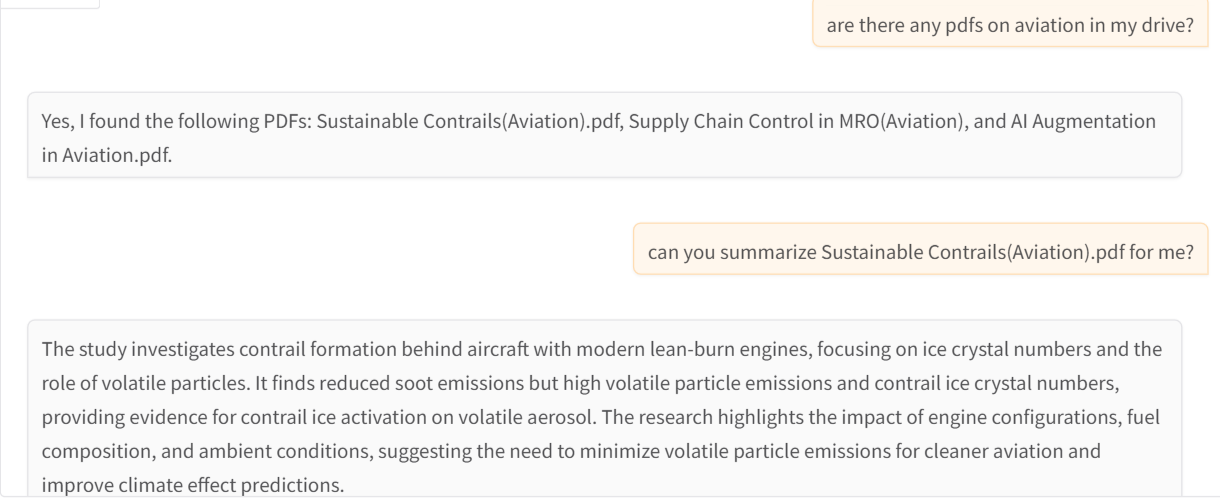

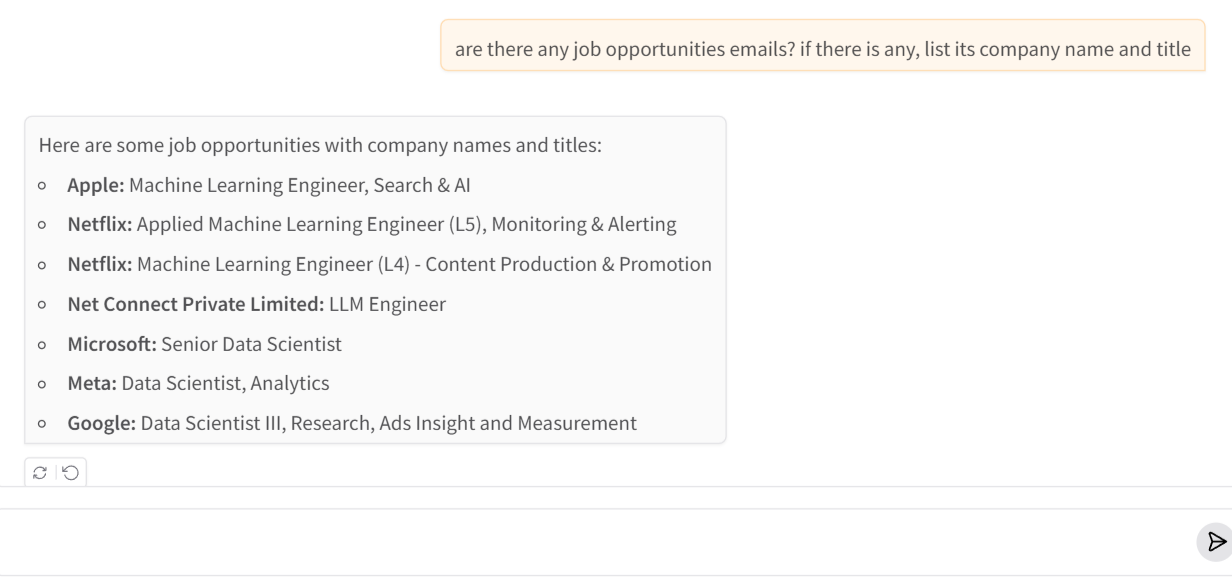